<a href="https://colab.research.google.com/github/pachterlab/GFCP_2021/blob/main/notebooks/vcy_scvelo_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Figure 1: The user-facing workflows of `velocyto` and `scVelo`

In this notebook, we reanalyze the La Manno et al. forebrain dataset using the default settings in `velocyto` and `scVelo`. The resulting PCA velocity embeddings lead to different conclusions about the relationships between the cells.

# Dependencies


In [51]:
%%capture
pip install scvelo==0.2.3 --quiet

In [52]:
%%capture
pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git

In [53]:
%%capture
pip install scanpy

In [54]:
%%capture
pip install umap-learn

In [55]:
!mkdir -p figure
!mkdir -p data

Obtain the data.

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!cp -r /content/drive/MyDrive/rnavelocity/hgForebrainGlut.loom /content/data

In [58]:
# from urllib.request import urlretrieve
# urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")

In [59]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
import umap

import velocyto as vcy
import anndata as ad
import warnings

import scvelo as scv
from vis import *

## velocyto

In [60]:
vlm = vcy.VelocytoLoom(loom_filepath="data/hgForebrainGlut.loom")

In [61]:
vlm.ca

{'CellID': array(['10X_17_028:AACCATGGTAATCACCx', '10X_17_028:AACCATGCATACTACGx',
        '10X_17_028:AAACCTGGTAAAGGAGx', ...,
        '10X_17_029:TTTGGTTGTACCCAATx', '10X_17_029:TTTCCTCCAGTCCTTCx',
        '10X_17_029:TTTGCGCCACAGATTCx'], dtype=object),
 'Clusters': array([3, 3, 1, ..., 6, 0, 1])}

In [62]:
preprocess(vlm)

#### phasePlots

Display a sample phase plot for ELAVL4, with imputation using $k=30$ neighbors (as in `scVelo`).

In [63]:
gene_idx_spec=int(np.where(vlm.ra['Gene']=="ELAVL4")[0][0])

In [64]:
getImputed(vlm, knn_k=50)

In [65]:
def plotPhase2(ax, vlm, gene_idx):
    '''
    Plot phase portrait
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    y=vlm.Ux[gene_idx,:]
    x=vlm.Sx[gene_idx,:]
    k=vlm.gammas[gene_idx]
    b=vlm.q[gene_idx]
    
    ax.scatter(x, y, c=vlm.colors)
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    x_=np.array([np.amin(x), np.amax(x)])
    ax.plot(x_, x_*k+b, color='black',linewidth=4,linestyle='dashed')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

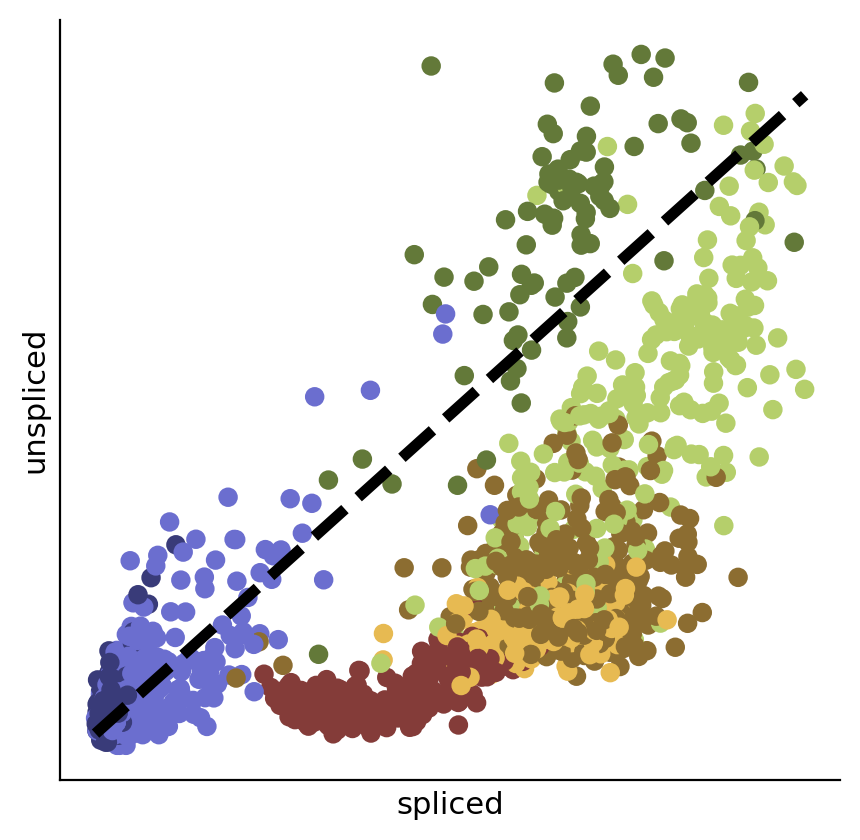

In [66]:
fig, ax = plt.subplots(figsize=(5,5))
plotPhase2(ax, vlm, gene_idx_spec)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.savefig('phase.pdf')


### Velocity Grid Embedding

This workflow reproduces the [notebook](https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/hgForebrainGlutamatergic.ipynb) used to generate Fig. 4 of "RNA Velocity of Single Cells."

In [70]:
vlm = vcy.VelocytoLoom("data/hgForebrainGlut.loom")

labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [71]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [72]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

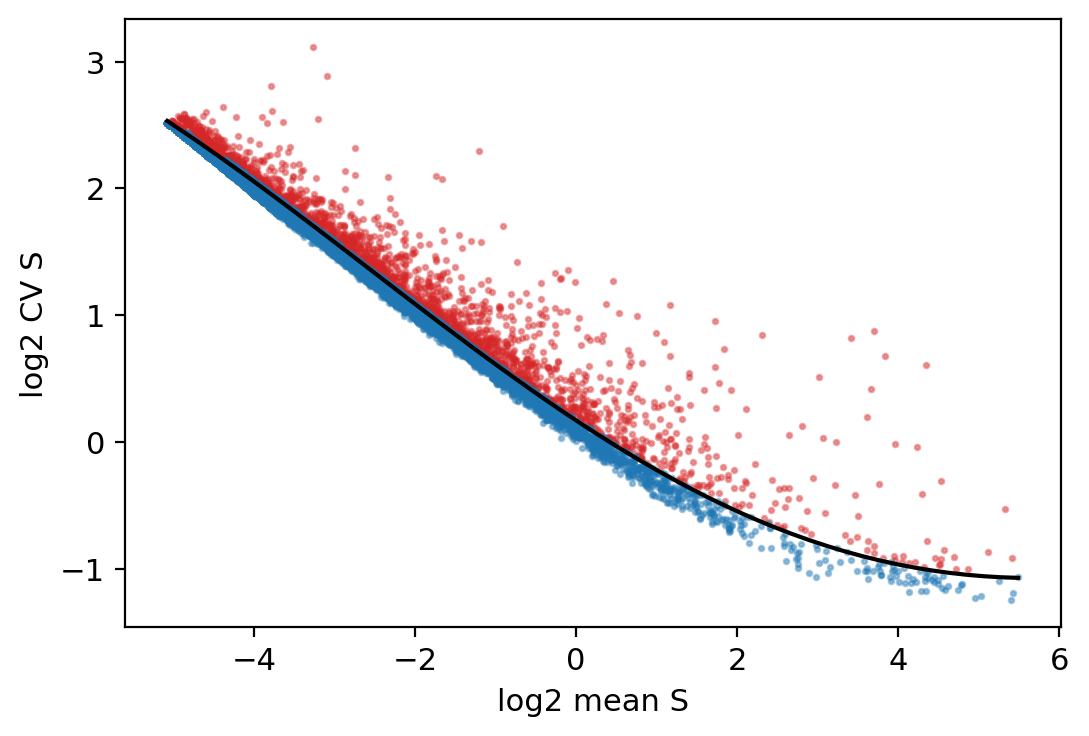

In [73]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [74]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

In [75]:
vlm.perform_PCA()
#plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 

In [76]:
!pip install igraph --quiet

In [77]:
from sklearn.neighbors import NearestNeighbors
import igraph

nn = NearestNeighbors(n_neighbors=50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [78]:
from numpy_groupies import aggregate, aggregate_np


In [30]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))


In [31]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [32]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [33]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [34]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [35]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

In [36]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

In [37]:
# labels = vlm.ca["Clusters"]
# cluster_colors_dict={l:colors20[l % 20,:] for l in labels}
# vlm.colors=[cluster_colors_dict[label] for label in labels]

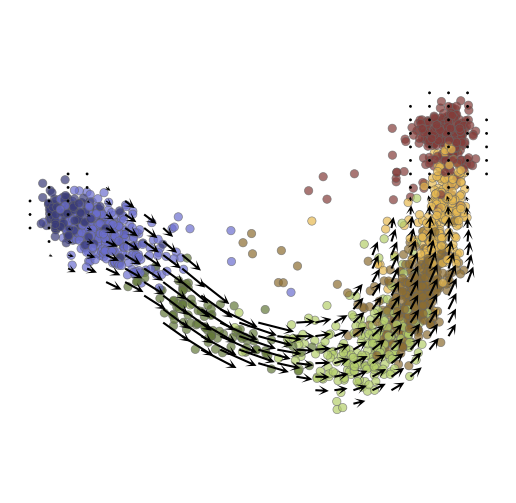

In [38]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
# plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
# plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

## scvelo

In [39]:
# update to the latest version, if not done yet.
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.3 (python 3.7.12) on 2022-02-09 04:48.


In [40]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [41]:
adata = scv.read('data/hgForebrainGlut.loom', cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [42]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 26764 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [43]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [44]:
adata

AnnData object with n_obs × n_vars = 1720 × 2000
    obs: 'Clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [45]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [46]:
#Get colors

In [47]:
labels = vlm.ca["Clusters"]
cluster_colors_dict={l:colors20[l % 20,:] for l in labels}
#colors=[cluster_colors_dict[label] for str(label) in labels]

In [48]:
cluster_colors_dict

{0: array([0.22352941, 0.23137255, 0.4745098 , 1.        ]),
 1: array([0.41960784, 0.43137255, 0.81176471, 1.        ]),
 2: array([0.38823529, 0.4745098 , 0.22352941, 1.        ]),
 3: array([0.70980392, 0.81176471, 0.41960784, 1.        ]),
 4: array([0.54901961, 0.42745098, 0.19215686, 1.        ]),
 5: array([0.90588235, 0.72941176, 0.32156863, 1.        ]),
 6: array([0.51764706, 0.23529412, 0.22352941, 1.        ])}

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


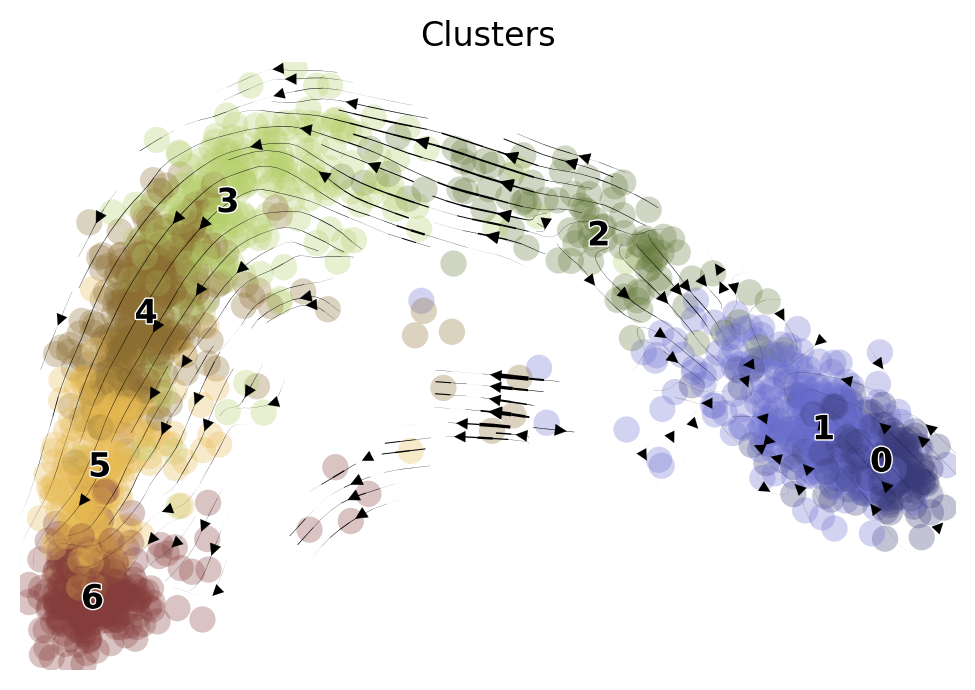

In [49]:
scv.pl.velocity_embedding_stream(adata, basis='pca',color='Clusters',palette=cluster_colors_dict)
